In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Load CIFAR-10 dataset
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

cuda


100%|██████████| 170498071/170498071 [00:02<00:00, 64642023.31it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Custom MLP

In [2]:
class Perceptron(nn.Module):
  def __init__(self, num_inputs):
    super(Perceptron, self).__init__()
    self.weights = nn.Parameter(nn.init.xavier_uniform_(torch.Tensor(1, num_inputs)))
    self.bias = nn.Parameter((torch.randn(1)))

  def propagate(self, inputs):
    output = torch.dot(inputs, self.weights.view(-1)) + self.bias
    return output

class MultiLayerPerceptron(nn.Module):
  def __init__(self):
    super(MultiLayerPerceptron, self).__init__()
    self.hidden_layer1 = nn.ModuleList([Perceptron(32 * 32 * 3) for i in range(128)])
    self.hidden_layer2 = nn.ModuleList([Perceptron(128) for i in range(64)])
    self.output_layer = nn.ModuleList([Perceptron(64) for i in range(10)])
    self.vector1 = []
    self.vector2 = []

  def propagate(self, inputs):
        # Flatten the input data
        inputs = inputs.view(-1, 32 * 32 * 3)

        # Store the matrices of weights
        hidden1_weights = torch.stack([perceptron.weights for perceptron in self.hidden_layer1])
        hidden1_weights = hidden1_weights.squeeze(dim=1)
        hidden2_weights = torch.stack([perceptron.weights for perceptron in self.hidden_layer2])
        hidden2_weights = hidden2_weights.squeeze(dim=1)
        output_weights = torch.stack([perceptron.weights for perceptron in self.output_layer])
        output_weights = output_weights.squeeze(dim=1)

        # Store the vectors of biases
        hidden1_bias = torch.stack([perceptron.bias for perceptron in self.hidden_layer1])
        hidden1_bias = hidden1_bias.view(-1)
        hidden2_bias = torch.stack([perceptron.bias for perceptron in self.hidden_layer2])
        hidden2_bias = hidden2_bias.view(-1)
        output_bias = torch.stack([perceptron.bias for perceptron in self.output_layer])
        output_bias = output_bias.view(-1)

        # Creating output list
        outputs_list = []

        for picture, pixels in enumerate(inputs):
          pixels1 = torch.relu(F.linear(pixels, hidden1_weights, hidden1_bias))
          pixels2 = torch.relu(F.linear(pixels1, hidden2_weights, hidden2_bias))
          outputs_list.append(F.linear(pixels2, output_weights, output_bias))

        self.vector1 = pixels1
        self.vector2 = pixels2

        # Concatenate the output tensors along the 0th dimension
        output = torch.stack(outputs_list)
        return output.squeeze()

In [3]:
# Assuming you have a function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [5]:
# Model Training
model = MultiLayerPerceptron()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)
num_epochs = 10
vector_1 = []
vector_2 = []
accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        images, labels = batch
        optimizer.zero_grad()
        outputs = model.propagate(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Calculate accuracy for the current batch
        batch_accuracy = calculate_accuracy(outputs, labels)
        correct += batch_accuracy * labels.size(0)
        total += labels.size(0)

    vector_1.append(model.vector1)
    vector_2.append(model.vector2)
    accuracy = correct / total
    accuracies.append(accuracy)
    print("Epoch:", epoch + 1, " Loss:", epoch_loss / len(train_loader))

Epoch: 1  Loss: 1.8459380593751094
Epoch: 2  Loss: 1.6017654225649431
Epoch: 3  Loss: 1.5124156106158595
Epoch: 4  Loss: 1.4507043584228476
Epoch: 5  Loss: 1.4025436411123446
Epoch: 6  Loss: 1.3603829590560834
Epoch: 7  Loss: 1.326811795344438
Epoch: 8  Loss: 1.296513227855458
Epoch: 9  Loss: 1.2673684882995722
Epoch: 10  Loss: 1.2421182381832385


In [6]:
vectors1 = [[0]*128 for _ in range(10)]
for epoch in range(10):
  for val in range(len(vector_1[epoch])):
    if vector_1[epoch][val] > 0:
      vectors1[epoch][val] = 1
    else:
      vectors1[epoch][val] = 0

vectors2 = [[0]*64 for _ in range(10)]
for epoch in range(10):
  for val in range(len(vector_2[epoch])):
    if vector_2[epoch][val] > 0:
      vectors2[epoch][val] = 1
    else:
      vectors2[epoch][val] = 0

In [8]:
# Model Testing
correct = 0
total = 0
with torch.no_grad():
  for batch in test_loader:
    images, labels = batch
    outputs = model.propagate(images)
    _,predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy1 = (correct / total)*100
print(accuracy1, "%")

49.34 %


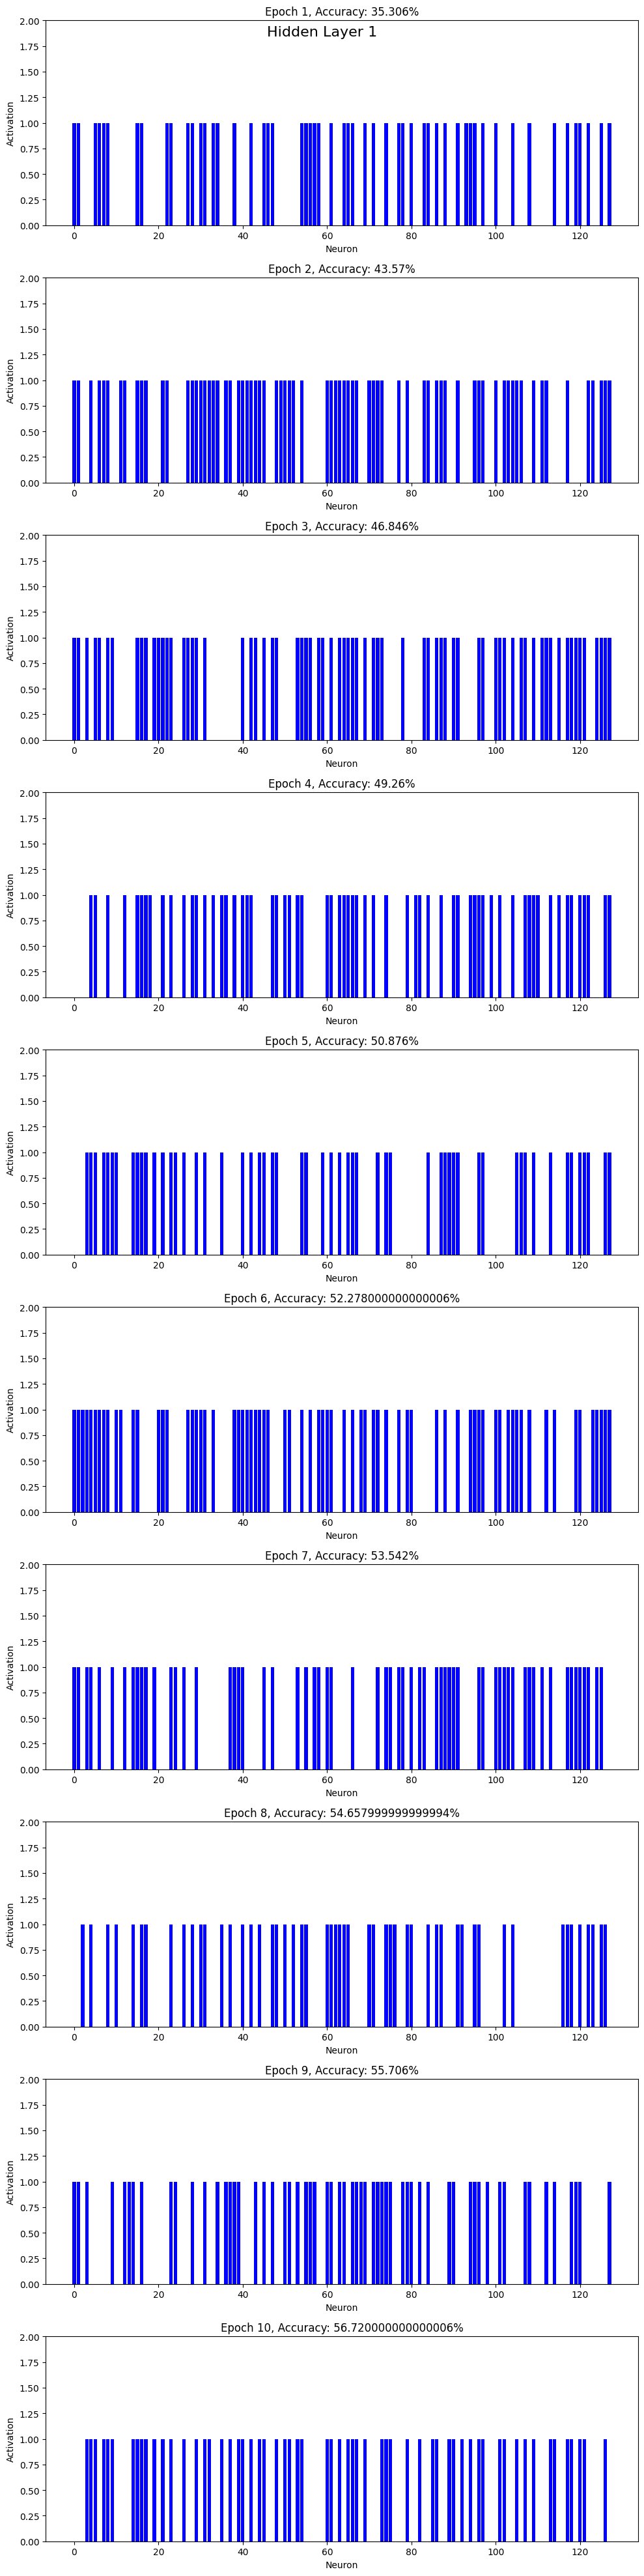

In [9]:
import matplotlib.pyplot as plt

# Create a figure with subplots for each epoch
num_epochs = len(vectors1)
fig, axes = plt.subplots(num_epochs, 1, figsize=(10, 4 * num_epochs))

# Add a figure title for the entire set of subplots
fig.suptitle('Hidden Layer 1', fontsize=16)

# Loop through all epochs and create bar charts
for i, ax in enumerate(axes):
    values = vectors1[i]
    x = range(len(values))
    ax.bar(x, values, color='blue')
    ax.set_title(f'Epoch {i + 1}, Accuracy: {accuracies[i]*100}%')
    ax.set_xlabel('Neuron')
    ax.set_ylabel('Activation')
    ax.set_ylim(0, 2)  # Set the y-axis limits between 0 and 1

plt.tight_layout()
plt.show()


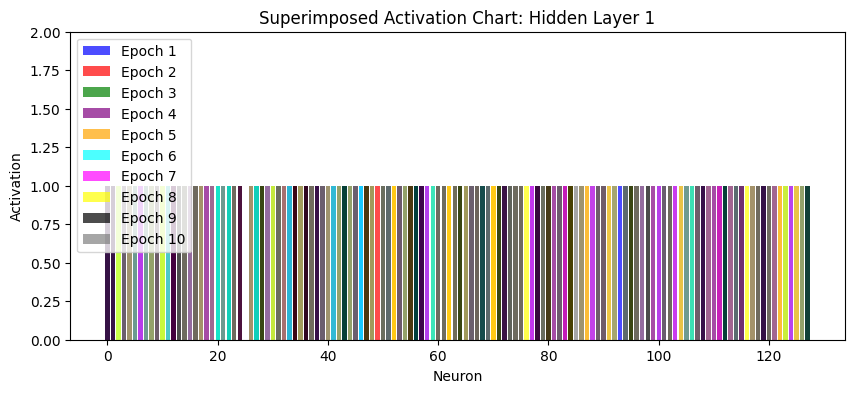

In [10]:
import matplotlib.pyplot as plt

# Create a single figure to superimpose the bar charts
fig, ax = plt.subplots(figsize=(10, 4))

# Loop through all epochs and create superimposed bar charts with different colors
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black', 'gray']

for i in range(len(vectors1)):
    values = vectors1[i]
    x = range(len(values))
    ax.bar(x, values, color=colors[i], alpha=0.7, label=f'Epoch {i + 1}')

ax.set_title('Superimposed Activation Chart: Hidden Layer 1')
ax.set_xlabel('Neuron')
ax.set_ylabel('Activation')
ax.set_ylim(0, 2)  # Set the y-axis limits between 0 and 1
ax.legend()

plt.show()


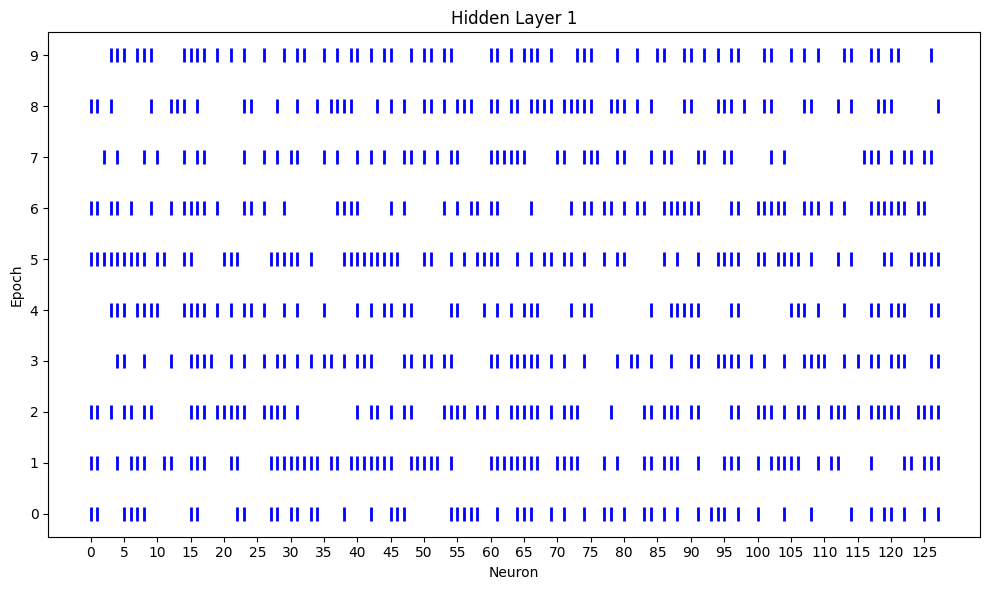

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a dot or cross for each neuron where the value is 1
for epoch in range(len(vectors1)):
    for neuron in range(len(vectors1[epoch])):
        if vectors1[epoch][neuron] == 1:
            marker = '|'
        else:
            marker = ''
        ax.plot(neuron, epoch, marker=marker, markersize=10, color='blue', markeredgewidth=2)

# Set labels and title
ax.set_xlabel('Neuron')
ax.set_ylabel('Epoch')
ax.set_title('Hidden Layer 1')

# Set the y-axis values from 0 to 9
ax.set_yticks(range(10))
ax.set_yticklabels(range(10))

# Set fewer x-axis values from 0 to 128 with a step of 10
ax.set_xticks(range(0, 129, 5))
ax.set_xticklabels(range(0, 129, 5))

plt.tight_layout()
plt.show()


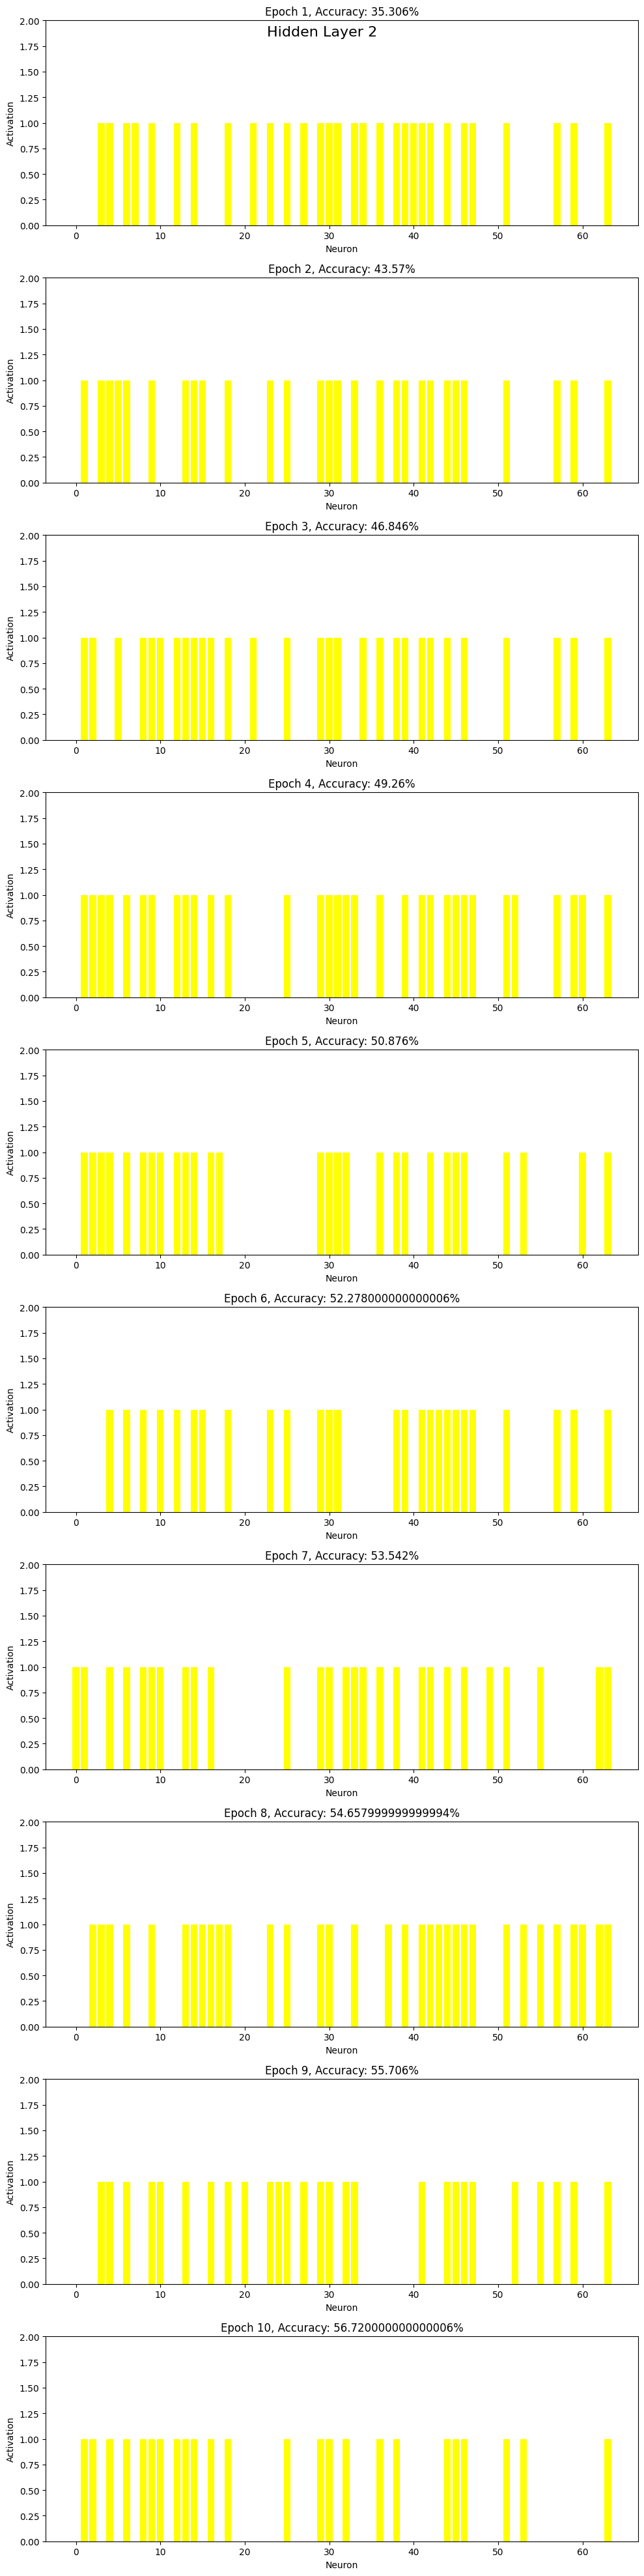

In [12]:
import matplotlib.pyplot as plt

# Create a figure with subplots for each epoch
num_epochs = len(vectors2)
fig, axes = plt.subplots(num_epochs, 1, figsize=(10, 4 * num_epochs))

# Add a figure title for the entire set of subplots
fig.suptitle('Hidden Layer 2', fontsize=16)

# Loop through all epochs and create bar charts
for i, ax in enumerate(axes):
    values = vectors2[i]
    x = range(len(values))
    ax.bar(x, values, color='yellow')
    ax.set_title(f'Epoch {i + 1}, Accuracy: {accuracies[i]*100}%')
    ax.set_xlabel('Neuron')
    ax.set_ylabel('Activation')
    ax.set_ylim(0, 2)  # Set the y-axis limits between 0 and 1

plt.tight_layout()
plt.show()


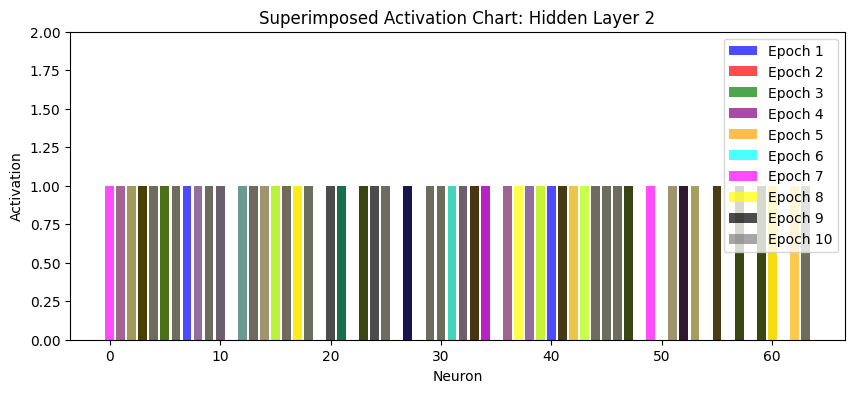

In [13]:
import matplotlib.pyplot as plt

# Create a single figure to superimpose the bar charts
fig, ax = plt.subplots(figsize=(10, 4))

# Loop through all epochs and create superimposed bar charts with different colors
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black', 'gray']

for i in range(len(vectors2)):
    values = vectors2[i]
    x = range(len(values))
    ax.bar(x, values, color=colors[i], alpha=0.7, label=f'Epoch {i + 1}')

ax.set_title('Superimposed Activation Chart: Hidden Layer 2')
ax.set_xlabel('Neuron')
ax.set_ylabel('Activation')
ax.set_ylim(0, 2)  # Set the y-axis limits between 0 and 1
ax.legend()

plt.show()


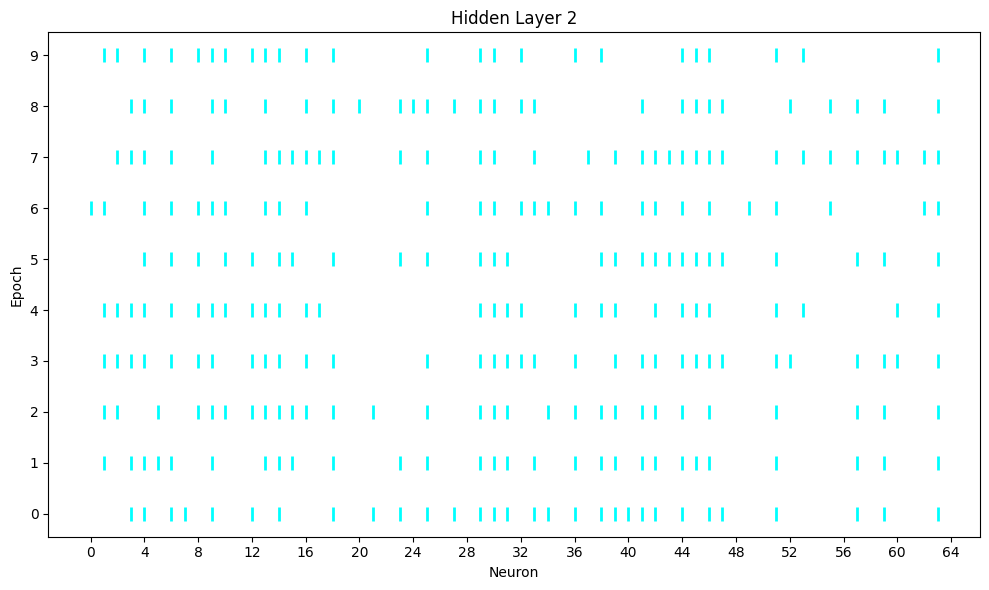

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a dot or cross for each neuron where the value is 1
for epoch in range(len(vectors2)):
    for neuron in range(len(vectors2[epoch])):
        if vectors2[epoch][neuron] == 1:
            marker = '|'
        else:
            marker = ''
        ax.plot(neuron, epoch, marker=marker, markersize=10, color='cyan', markeredgewidth=2)

# Set labels and title
ax.set_xlabel('Neuron')
ax.set_ylabel('Epoch')
ax.set_title('Hidden Layer 2')

# Set the y-axis values from 0 to 9
ax.set_yticks(range(10))
ax.set_yticklabels(range(10))

# Set fewer x-axis values from 0 to 128 with a step of 10
ax.set_xticks(range(0, 65, 4))
ax.set_xticklabels(range(0, 65, 4))

plt.tight_layout()
plt.show()


# Pointwise AND operation Epochs 1-9

In [15]:
array_and = [1]*128
for neuron in range(128):
  for epoch in range(9):
    array_and[neuron] *= vectors1[epoch][neuron]
print(array_and)
print(vectors1[9])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0]


In [16]:
def hamming_distance(array1, array2):
    # Check if the arrays have the same length
    if len(array1) != len(array2):
        raise ValueError("Arrays must have the same length")

    # Initialize a variable to keep track of the distance
    distance = 0

    # Iterate through the arrays and count the differing elements
    for i in range(len(array1)):
        if array1[i] != array2[i]:
            distance += 1

    return distance

# Example usage:
distance = hamming_distance(array_and, vectors1[9])
print("Hamming Distance (hidden layer 1):", distance)


Hamming Distance (hidden layer 1): 60


In [17]:
array_and = [1]*64
for neuron in range(64):
  for epoch in range(9):
    array_and[neuron] *= vectors2[epoch][neuron]
print(array_and)
print(vectors2[9])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [18]:
# Example usage:
distance = hamming_distance(array_and, vectors2[9])
print("Hamming Distance (hidden layer 2):", distance)

Hamming Distance (hidden layer 2): 19


# Summation of 0s and 1s

In [19]:
for i, vector in enumerate(vectors1):
    count_zeros = vector.count(0)
    count_ones = vector.count(1)
    print(f"Epoch {i + 1}: Number of 0s = {count_zeros}, Number of 1s = {count_ones}")

Epoch 1: Number of 0s = 73, Number of 1s = 55
Epoch 2: Number of 0s = 54, Number of 1s = 74
Epoch 3: Number of 0s = 56, Number of 1s = 72
Epoch 4: Number of 0s = 64, Number of 1s = 64
Epoch 5: Number of 0s = 72, Number of 1s = 56
Epoch 6: Number of 0s = 56, Number of 1s = 72
Epoch 7: Number of 0s = 65, Number of 1s = 63
Epoch 8: Number of 0s = 75, Number of 1s = 53
Epoch 9: Number of 0s = 68, Number of 1s = 60
Epoch 10: Number of 0s = 67, Number of 1s = 61


In [20]:
for i, vector in enumerate(vectors2):
    count_zeros = vector.count(0)
    count_ones = vector.count(1)
    print(f"Epoch {i + 1}: Number of 0s = {count_zeros}, Number of 1s = {count_ones}")

Epoch 1: Number of 0s = 34, Number of 1s = 30
Epoch 2: Number of 0s = 36, Number of 1s = 28
Epoch 3: Number of 0s = 35, Number of 1s = 29
Epoch 4: Number of 0s = 32, Number of 1s = 32
Epoch 5: Number of 0s = 36, Number of 1s = 28
Epoch 6: Number of 0s = 38, Number of 1s = 26
Epoch 7: Number of 0s = 37, Number of 1s = 27
Epoch 8: Number of 0s = 31, Number of 1s = 33
Epoch 9: Number of 0s = 37, Number of 1s = 27
Epoch 10: Number of 0s = 40, Number of 1s = 24


## Histogram of Frequencies of Gaps

In [21]:
# Hidden Layer 1
frequencies = []
for vector in vectors1:
  count = 0
  gaps = []
  for i in range(128):
    if vector[i] == 0:
      count+=1
    else:
      if count != 0:
        gaps.append(count)
      count = 0
  frequencies.append(gaps)

In [22]:
# Hidden Layer 2
frequencies2 = []
for vector in vectors2:
  count = 0
  gaps = []
  for i in range(64):
    if vector[i] == 0:
      count+=1
    else:
      if count != 0:
        gaps.append(count)
      count = 0
  frequencies2.append(gaps)

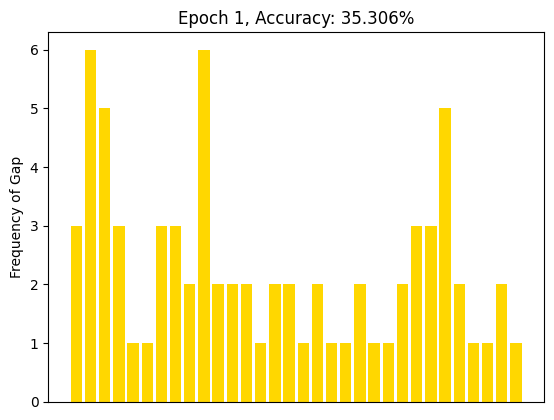

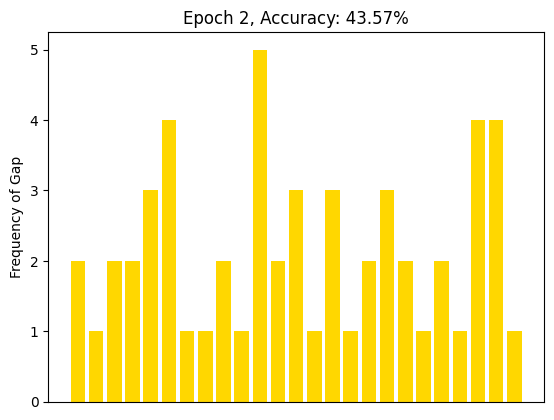

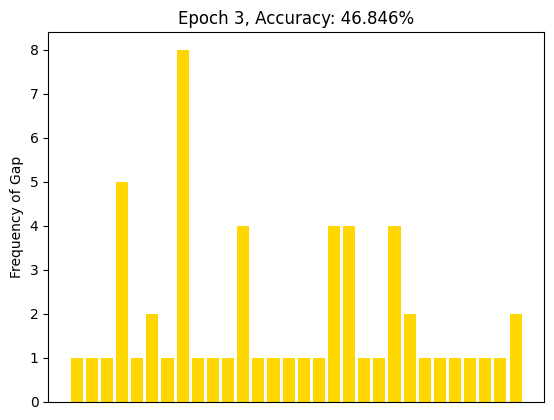

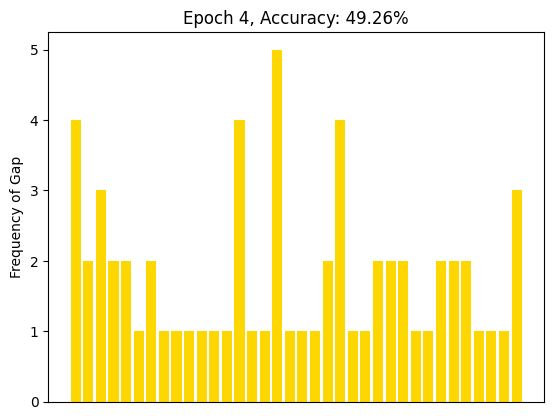

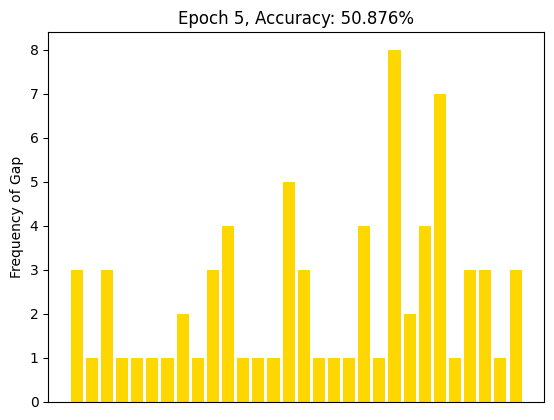

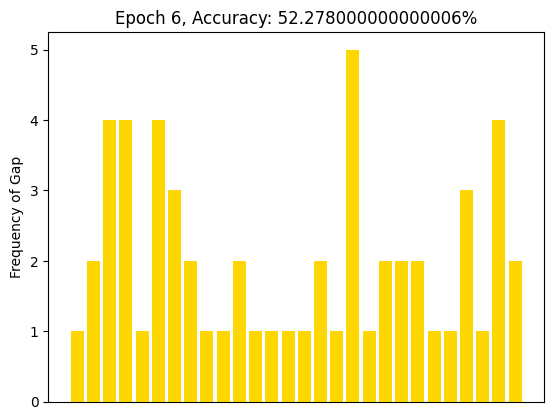

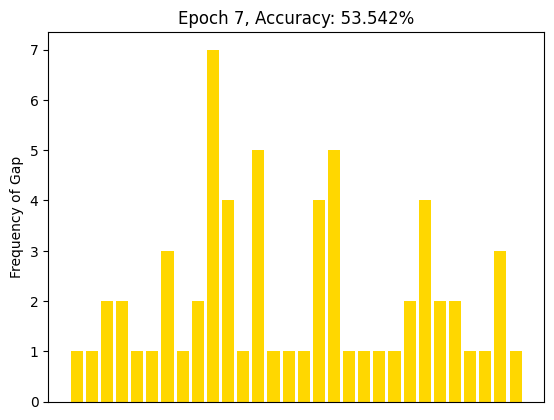

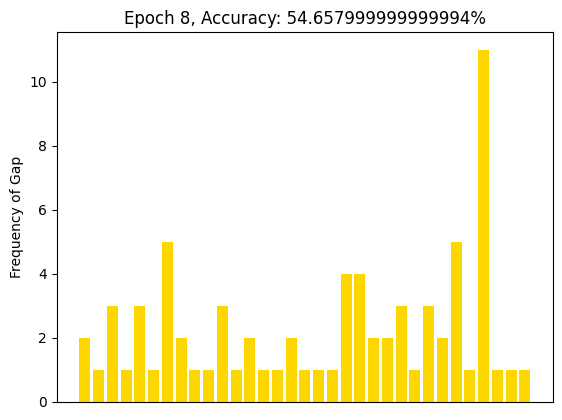

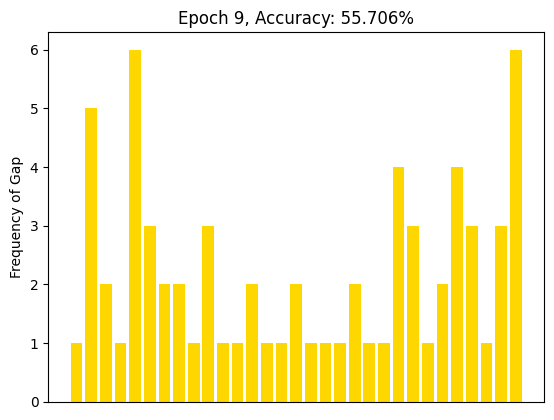

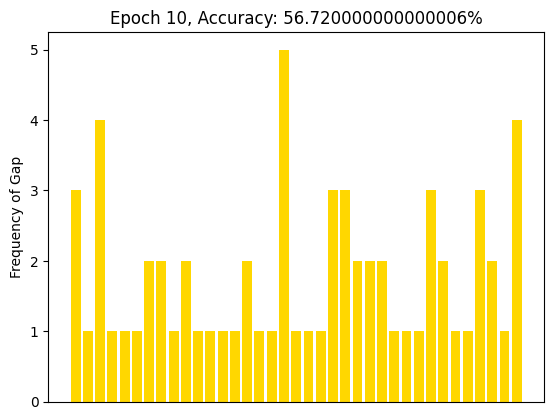

In [23]:
# Plot bar charts for each list in 'frequencies' with a blank x-axis
for i, data in enumerate(frequencies):
    plt.figure()
    x = list(range(len(data)))
    plt.bar(x, data, color='gold')
    plt.title(f'Epoch {i + 1}, Accuracy: {accuracies[i] * 100}%')
    plt.xlabel('')
    plt.ylabel('Frequency of Gap')
    plt.xticks([])
    plt.show()

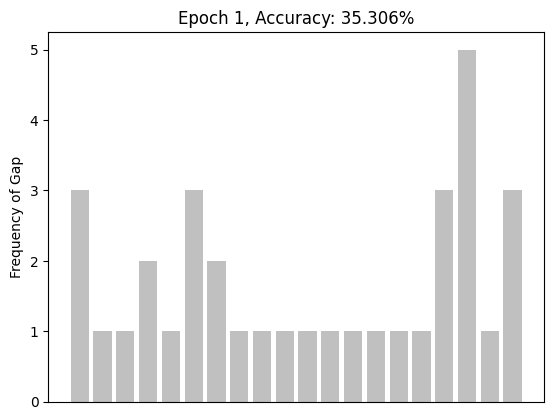

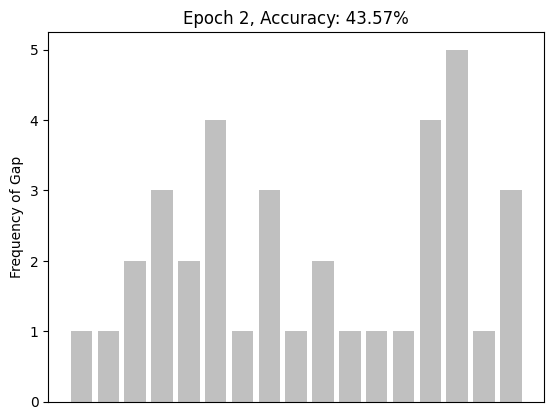

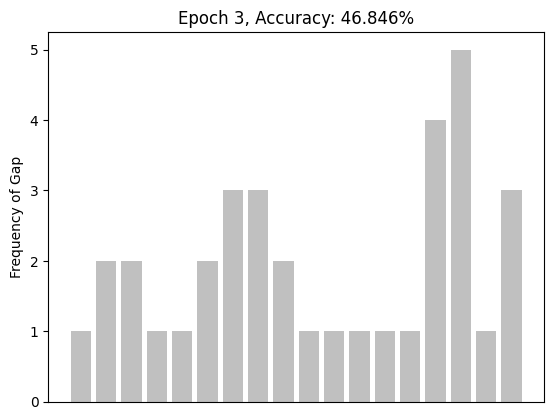

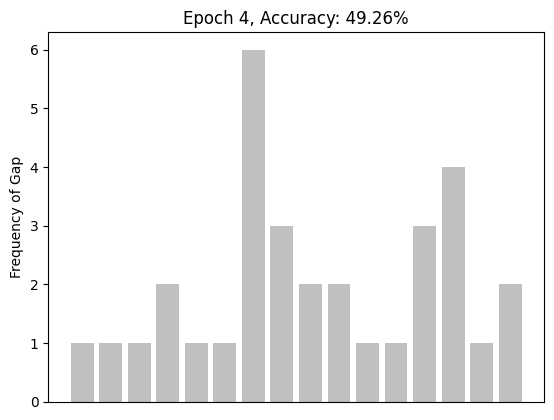

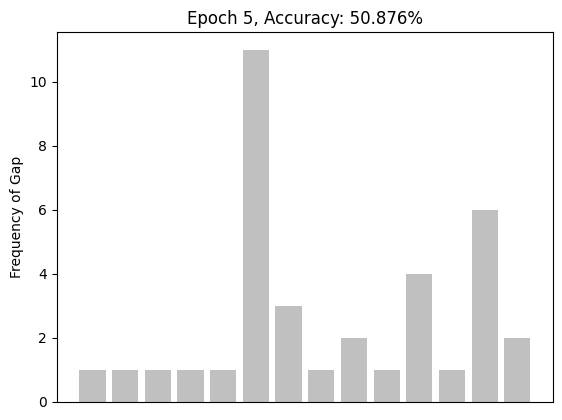

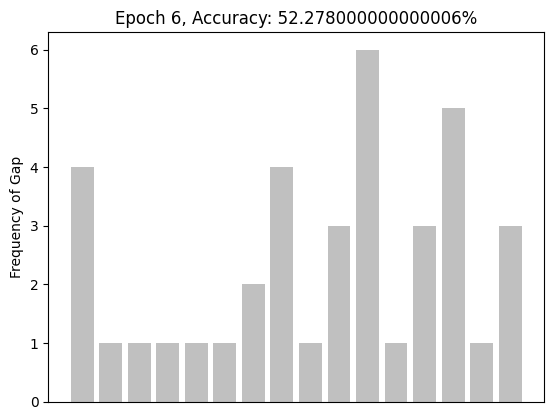

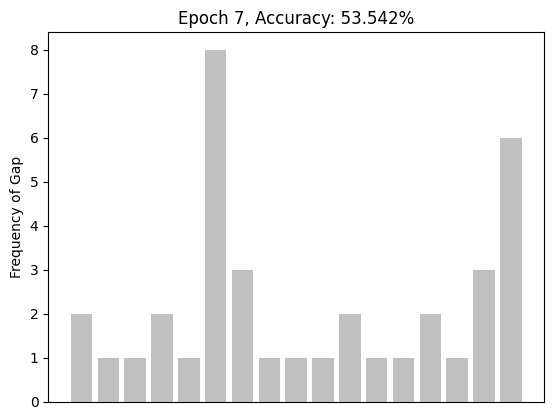

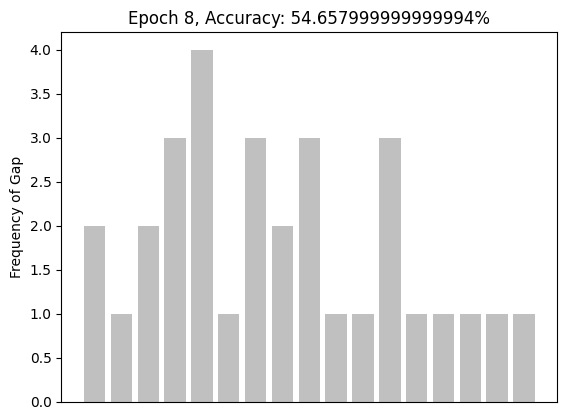

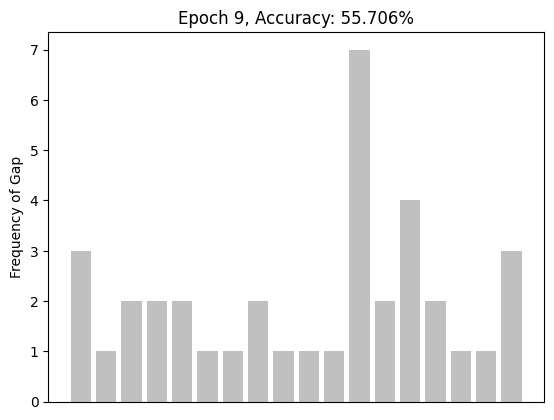

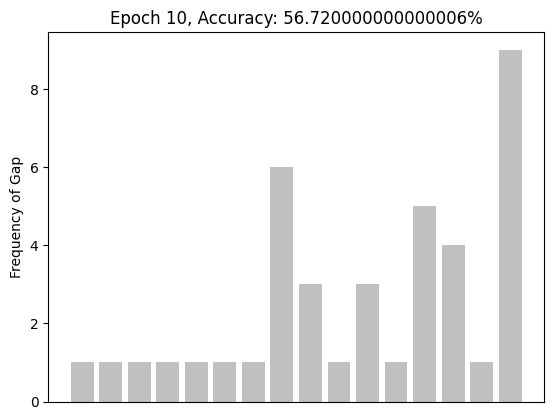

In [24]:
# Plot bar charts for each list in 'frequencies' with a blank x-axis
for i, data in enumerate(frequencies2):
    plt.figure()
    x = list(range(len(data)))
    plt.bar(x, data, color='silver')
    plt.title(f'Epoch {i + 1}, Accuracy: {accuracies[i] * 100}%')
    plt.xlabel('')
    plt.ylabel('Frequency of Gap')
    plt.xticks([])
    plt.show()

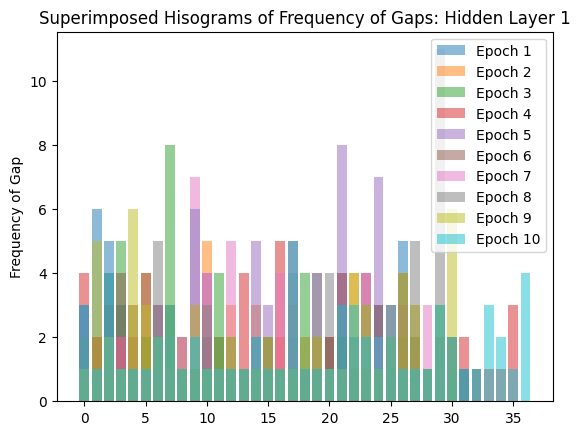

In [25]:
# Create a single figure to superimpose the bar charts
plt.figure()

# Iterate through 'frequencies' and plot bars
for i, data in enumerate(frequencies):
    x = list(range(len(data)))
    plt.bar(x, data, alpha=0.5, label=f'Epoch {i + 1}')

plt.title('Superimposed Hisograms of Frequency of Gaps: Hidden Layer 1')
plt.xlabel('')
plt.ylabel('Frequency of Gap')
plt.legend()
plt.show()

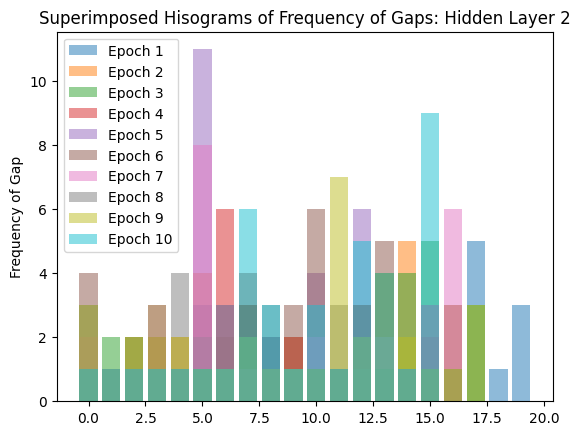

In [26]:
# Create a single figure to superimpose the bar charts
plt.figure()

# Iterate through 'frequencies' and plot bars
for i, data in enumerate(frequencies2):
    x = list(range(len(data)))
    plt.bar(x, data, alpha=0.5, label=f'Epoch {i + 1}')

plt.title('Superimposed Hisograms of Frequency of Gaps: Hidden Layer 2')
plt.xlabel('')
plt.ylabel('Frequency of Gap')
plt.legend()
plt.show()

#Kernel Distribution Estimation

## Gaussian Kernel

In [27]:
# # Importing the necessary libraries
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import gaussian_kde

# # Bandwidth parameter (adjust this)
# bandwidth = 0.1

# def plot_kde(weights, name):
#     plt.figure(figsize=(8, 4))
#     plt.title(f'{name} - Epoch 1 - 10')

#     for epoch in range(num_epochs):
#         # Create a KDE object with Gaussian kernel
#         kde = gaussian_kde(weights[epoch][0][0], bw_method=bandwidth)

#         # Define a range of x values for the PDF
#         x_values = np.linspace(min(weights[epoch][0][0]), max(weights[epoch][0][0]), 1000)

#         # Calculate the estimated PDF at each x value
#         pdf_values = kde(x_values)

#         # Plot the KDE estimate
#         plt.plot(x_values, pdf_values, label=f'Epoch {epoch + 1}')
#     # plt.title(f'KDE with Gaussian Kernel - Epoch {epoch + 1}')
#     plt.xlabel('Weight')
#     plt.ylabel('Estimated Density')
#     plt.legend()
#     plt.show()

# # Loop through weight distributions for each epoch
# for idx, (name, param) in enumerate(model.named_parameters()):
#   if 'weight' in name:
#       plot_kde([weight_history[i][idx] for i in range(num_epochs)], name)

# KL Divergence of Weight Distributions among Neurons per Layer per Epoch

## Standard Deviation

In [28]:
# import matplotlib.pyplot as plt
# import torch
# from scipy.special import kl_div

# # Initialize lists to store standard deviations for each layer across epochs
# std_deviations_hidden1 = []
# std_deviations_hidden2 = []
# std_deviations_hidden3 = []
# std_deviations_output = []

# # Loop over each epoch - 10 times
# for epoch in range(num_epochs):
#     kl_divergences = [[0.0] * 127, [0.0] * 63, [0.0] * 32, [0.0] * 9]  # Store KL divergences for each layer
#     hidden1_idx = 0
#     hidden2_idx = 0
#     hidden3_idx = 0
#     output_idx = 0
#     for idx, (name, param) in enumerate(model.named_parameters()):
#         if 'weight' in name:
#             if 'hidden_layer1' in name:
#                 if idx < 254:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx + 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     kl_divergences[0][hidden1_idx] = kl_divergence
#                     hidden1_idx += 1
#             elif 'hidden_layer2' in name:
#                 if idx < 382:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx + 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     kl_divergences[1][hidden2_idx] = kl_divergence
#                     hidden2_idx += 1
#             elif 'hidden_layer3' in name:
#                 if idx < 446:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx + 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     kl_divergences[2][hidden3_idx] = kl_divergence
#                     hidden3_idx += 1
#             elif 'output_layer' in name:
#                 if idx < 466:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx + 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     kl_divergences[3][output_idx] = kl_divergence
#                     output_idx += 1

#     # Calculate the standard deviation for each layer and store it for this epoch
#     std_hidden1 = torch.std(torch.tensor(kl_divergences[0]))
#     std_hidden2 = torch.std(torch.tensor(kl_divergences[1]))
#     std_hidden3 = torch.std(torch.tensor(kl_divergences[2]))
#     std_output = torch.std(torch.tensor(kl_divergences[3]))

#     std_deviations_hidden1.append(std_hidden1.item())
#     std_deviations_hidden2.append(std_hidden2.item())
#     std_deviations_hidden3.append(std_hidden3.item())
#     std_deviations_output.append(std_output.item())

# # Create subplots for each layer
# fig, axs = plt.subplots(4, figsize=(8, 12))

# # Plot standard deviation of KL divergence for Hidden Layer 1
# axs[0].plot(range(1, num_epochs + 1), std_deviations_hidden1, marker='o', linestyle='-', color='blue')
# axs[0].set_title('Standard Deviation of KL Divergence for Hidden Layer 1')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Standard Deviation')

# # Plot standard deviation of KL divergence for Hidden Layer 2
# axs[1].plot(range(1, num_epochs + 1), std_deviations_hidden2, marker='o', linestyle='-', color='green')
# axs[1].set_title('Standard Deviation of KL Divergence for Hidden Layer 2')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Standard Deviation')

# # Plot standard deviation of KL divergence for Hidden Layer 2
# axs[2].plot(range(1, num_epochs + 1), std_deviations_hidden3, marker='o', linestyle='-', color='red')
# axs[2].set_title('Standard Deviation of KL Divergence for Hidden Layer 3')
# axs[2].set_xlabel('Epoch')
# axs[2].set_ylabel('Standard Deviation')

# # Plot standard deviation of KL divergence for Output Layer
# axs[3].plot(range(1, num_epochs + 1), std_deviations_output, marker='o', linestyle='-', color='pink')
# axs[3].set_title('Standard Deviation of KL Divergence for Output Layer')
# axs[3].set_xlabel('Epoch')
# axs[3].set_ylabel('Standard Deviation')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()


In [29]:
# # Create a single plot for all layers
# plt.figure(figsize=(8, 4))

# # Plot standard deviation of KL divergence for Hidden Layer 1
# plt.plot(range(1, num_epochs + 1), std_deviations_hidden1, marker='o', linestyle='-', color='blue', label='Hidden Layer 1')

# # Plot standard deviation of KL divergence for Hidden Layer 2
# plt.plot(range(1, num_epochs + 1), std_deviations_hidden2, marker='o', linestyle='-', color='green', label='Hidden Layer 2')

# # Plot standard deviation of KL divergence for Hidden Layer 3
# plt.plot(range(1, num_epochs + 1), std_deviations_hidden3, marker='o', linestyle='-', color='red', label='Hidden Layer 3')

# # Plot standard deviation of KL divergence for Output Layer
# # plt.plot(range(1, num_epochs + 1), std_deviations_output, marker='o', linestyle='-', color='red', label='Output Layer')

# plt.title('Standard Deviation of KL Divergence Across Layers')
# plt.xlabel('Epoch')
# plt.ylabel('Standard Deviation')
# plt.legend()

# # Show the plot
# plt.tight_layout()
# plt.show()

In [30]:
# # Initialize lists to store standard deviations for each layer across epochs
# reverse_std_deviations_hidden1 = []
# reverse_std_deviations_hidden2 = []
# reverse_std_deviations_hidden3 = []
# reverse_std_deviations_output = []

# # Loop over each epoch - 10 times
# for epoch in range(num_epochs):
#     reverse_kl_divergences = [[0.0] * 127, [0.0] * 63, [0.0] * 32, [0.0] * 9]  # Store KL divergences for each layer
#     hidden1_idx = 0
#     hidden2_idx = 0
#     hidden3_idx = 0
#     output_idx = 0
#     for idx, (name, param) in reversed(list(enumerate(model.named_parameters()))):
#         if 'weight' in name:
#             if 'hidden_layer1' in name:
#                 if idx > 3:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx - 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     reverse_kl_divergences[0][hidden1_idx] = kl_divergence
#                     hidden1_idx += 1
#             elif 'hidden_layer2' in name:
#                 if idx > 256:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx - 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     reverse_kl_divergences[1][hidden2_idx] = kl_divergence
#                     hidden2_idx += 1
#             elif 'hidden_layer3' in name:
#                 if idx > 384:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx - 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     reverse_kl_divergences[2][hidden3_idx] = kl_divergence
#                     hidden3_idx += 1
#             elif 'output_layer' in name:
#                 if idx > 448:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx - 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     reverse_kl_divergences[3][output_idx] = kl_divergence
#                     output_idx += 1

#     # Calculate the standard deviation for each layer and store it for this epoch
#     std_hidden1 = torch.std(torch.tensor(reverse_kl_divergences[0]))
#     std_hidden2 = torch.std(torch.tensor(reverse_kl_divergences[1]))
#     std_hidden3 = torch.std(torch.tensor(reverse_kl_divergences[2]))
#     std_output = torch.std(torch.tensor(reverse_kl_divergences[3]))

#     reverse_std_deviations_hidden1.append(std_hidden1.item())
#     reverse_std_deviations_hidden2.append(std_hidden2.item())
#     reverse_std_deviations_hidden3.append(std_hidden3.item())
#     reverse_std_deviations_output.append(std_output.item())

# # Create subplots for each layer
# fig, axs = plt.subplots(4, figsize=(8, 12))

# # Plot standard deviation of KL divergence for Hidden Layer 1
# axs[0].plot(range(1, num_epochs + 1), reverse_std_deviations_hidden1, marker='o', linestyle='-', color='blue')
# axs[0].set_title('Standard Deviation of KL Divergence for Hidden Layer 1')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Standard Deviation')

# # Plot standard deviation of KL divergence for Hidden Layer 2
# axs[1].plot(range(1, num_epochs + 1), reverse_std_deviations_hidden2, marker='o', linestyle='-', color='green')
# axs[1].set_title('Standard Deviation of KL Divergence for Hidden Layer 2')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Standard Deviation')

# # Plot standard deviation of KL divergence for Hidden Layer 2
# axs[2].plot(range(1, num_epochs + 1), reverse_std_deviations_hidden3, marker='o', linestyle='-', color='red')
# axs[2].set_title('Standard Deviation of KL Divergence for Hidden Layer 3')
# axs[2].set_xlabel('Epoch')
# axs[2].set_ylabel('Standard Deviation')

# # Plot standard deviation of KL divergence for Output Layer
# axs[3].plot(range(1, num_epochs + 1), reverse_std_deviations_output, marker='o', linestyle='-', color='pink')
# axs[3].set_title('Standard Deviation of KL Divergence for Output Layer')
# axs[3].set_xlabel('Epoch')
# axs[3].set_ylabel('Standard Deviation')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()


In [31]:
# # Create a single plot for all layers
# plt.figure(figsize=(8, 4))

# # Plot standard deviation of KL divergence for Hidden Layer 1
# plt.plot(range(1, num_epochs + 1), reverse_std_deviations_hidden1, marker='o', linestyle='-', color='blue', label='Hidden Layer 1')

# # Plot standard deviation of KL divergence for Hidden Layer 2
# plt.plot(range(1, num_epochs + 1), reverse_std_deviations_hidden2, marker='o', linestyle='-', color='green', label='Hidden Layer 2')

# # Plot standard deviation of KL divergence for Hidden Layer 3
# plt.plot(range(1, num_epochs + 1), reverse_std_deviations_hidden3, marker='o', linestyle='-', color='red', label='Hidden Layer 3')

# # Plot standard deviation of KL divergence for Output Layer
# # plt.plot(range(1, num_epochs + 1), std_deviations_output, marker='o', linestyle='-', color='red', label='Output Layer')

# plt.title('Standard Deviation of KL Divergence Across Layers - Reverse Order')
# plt.xlabel('Epoch')
# plt.ylabel('Standard Deviation')
# plt.legend()

# # Show the plot
# plt.tight_layout()
# plt.show()

# Prebuilt Neuron Analysis

In [32]:
# # Define a simple feedforward neural network
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.hidden_layer1 = nn.Linear(28 * 28, 128)  # Input: 28x28 image, Output: 128
#         self.hidden_layer2 = nn.Linear(128, 64)      # Hidden layer: 128 -> 64
#         self.hidden_layer3 = nn.Linear(64, 32)      # Hidden layer: 64 -> 32
#         self.output_layer = nn.Linear(32, 10)      # Output: 32 -> 10 (10 classes for MNIST)

#     def forward(self, x):
#         x = x.view(-1, 28 * 28)  # Flatten the input
#         x = torch.relu(self.hidden_layer1(x))
#         x = torch.relu(self.hidden_layer2(x))
#         x = torch.relu(self.hidden_layer3(x))
#         x = self.output_layer(x)
#         return x

In [33]:
# # Initialize the model, loss function, and optimizer
# model = NeuralNetwork()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)
# num_epochs = 10

# weight_history = [[[] for _ in range(8)] for _ in range(num_epochs)]
# bias_history = [[[] for _ in range(8)] for _ in range(num_epochs)]

# for epoch in range(num_epochs):
#     epoch_loss = 0
#     for batch in trainloader:
#         images, labels = batch
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     for idx, param in enumerate(model.named_parameters()):
#         if idx%2!=1:
#             weight_history[epoch][idx].append(param[1].data.clone())
#         else:
#             bias_history[epoch][idx].append(param[1].data.clone())

#     print("Epoch:", epoch + 1, " Loss:", epoch_loss / len(trainloader))


In [34]:
# # Model Testing
# correct = 0
# total = 0
# with torch.no_grad():
#   for batch in testloader:
#     images, labels = batch
#     outputs = model(images)
#     _,predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()
# accuracy2 = (correct / total)*100
# print(accuracy2, "%")

In [35]:
# # KL Divergence
# import matplotlib.pyplot as plt
# import torch
# from scipy.special import kl_div

# # Initialize lists to store standard deviations for each layer across epochs
# std_deviations_hidden1 = []
# std_deviations_hidden2 = []
# std_deviations_hidden3 = []
# std_deviations_output = []

# # Loop over each epoch - 10 times
# for epoch in range(num_epochs):
#     kl_divergences = [[0.0] * 127, [0.0] * 63, [0.0] * 32, [0.0] * 9]  # Store KL divergences for each layer
#     hidden1_idx = 0
#     hidden2_idx = 0
#     hidden3_idx = 0
#     output_idx = 0
#     for idx, (name, param) in enumerate(model.named_parameters()):
#         if 'weight' in name:
#             print(name)
#             if 'hidden_layer1' in name:
#                 if idx < 254:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx + 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     kl_divergences[0][hidden1_idx] = kl_divergence
#                     hidden1_idx += 1
#             elif 'hidden_layer2' in name:
#                 if idx < 382:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx + 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     kl_divergences[1][hidden2_idx] = kl_divergence
#                     hidden2_idx += 1
#             elif 'hidden_layer3' in name:
#                 if idx < 446:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx + 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     kl_divergences[2][hidden3_idx] = kl_divergence
#                     hidden3_idx += 1
#             elif 'output_layer' in name:
#                 if idx < 466:
#                     # Calculate the KL divergence
#                     kl_divergence = kl_div(weight_history[epoch][idx][0][0],
#                                            weight_history[epoch][idx + 2][0][0])
#                     kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
#                     kl_divergence = sum(kl_divergence)
#                     kl_divergences[3][output_idx] = kl_divergence
#                     output_idx += 1

#     # Calculate the standard deviation for each layer and store it for this epoch
#     std_hidden1 = torch.std(torch.tensor(kl_divergences[0]))
#     std_hidden2 = torch.std(torch.tensor(kl_divergences[1]))
#     std_hidden3 = torch.std(torch.tensor(kl_divergences[2]))
#     std_output = torch.std(torch.tensor(kl_divergences[3]))

#     std_deviations_hidden1.append(std_hidden1.item())
#     std_deviations_hidden2.append(std_hidden2.item())
#     std_deviations_hidden3.append(std_hidden3.item())
#     std_deviations_output.append(std_output.item())

# # Create subplots for each layer
# fig, axs = plt.subplots(4, figsize=(8, 12))

# # Plot standard deviation of KL divergence for Hidden Layer 1
# axs[0].plot(range(1, num_epochs + 1), std_deviations_hidden1, marker='o', linestyle='-', color='blue')
# axs[0].set_title('Standard Deviation of KL Divergence for Hidden Layer 1')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Standard Deviation')

# # Plot standard deviation of KL divergence for Hidden Layer 2
# axs[1].plot(range(1, num_epochs + 1), std_deviations_hidden2, marker='o', linestyle='-', color='green')
# axs[1].set_title('Standard Deviation of KL Divergence for Hidden Layer 2')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Standard Deviation')

# # Plot standard deviation of KL divergence for Hidden Layer 2
# axs[2].plot(range(1, num_epochs + 1), std_deviations_hidden3, marker='o', linestyle='-', color='red')
# axs[2].set_title('Standard Deviation of KL Divergence for Hidden Layer 3')
# axs[2].set_xlabel('Epoch')
# axs[2].set_ylabel('Standard Deviation')

# # Plot standard deviation of KL divergence for Output Layer
# axs[3].plot(range(1, num_epochs + 1), std_deviations_output, marker='o', linestyle='-', color='pink')
# axs[3].set_title('Standard Deviation of KL Divergence for Output Layer')
# axs[3].set_xlabel('Epoch')
# axs[3].set_ylabel('Standard Deviation')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()
